# Overview
This project analyzes and creates predictive models for a dataset of wind power generation. This dataset represents several years of data points taken every 10 minutes from January 2018 to March 2020. These data points include information on power generation, internal part temperatures, wind speed, wind direction, etc. There are many missing values in the dataset.

The dataset came with the suggested goal of predicting power output 15 days ahead of known/trained data.

I will explore and clean the dataset before applying a variety of techniques to the task including a baseline linear regression, a few different SARIMA/SARIMAX models, and finish off with using the XGBoost algorithm for boosted trees.

### Keywords
data cleaning, forecasting, regression, time series, SARIMA/SARIMAX, boosted trees, XGBoost

In [264]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import max_error
from sklearn.metrics import r2_score
import statsmodels.api as sm
import pmdarima
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
import xgboost

### Exploration and cleaning

In [389]:
df = pd.read_csv('Turbine_Data.csv',index_col='Unnamed: 0')

In [390]:
df.head()

,ActivePower,AmbientTemperatue,BearingShaftTemperature,Blade1PitchAngle,Blade2PitchAngle,Blade3PitchAngle,ControlBoxTemperature,GearboxBearingTemperature,GearboxOilTemperature,GeneratorRPM,...,GeneratorWinding2Temperature,HubTemperature,MainBoxTemperature,NacellePosition,ReactivePower,RotorRPM,TurbineStatus,WTG,WindDirection,WindSpeed
2017-12-31 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G01,NaN,NaN
2017-12-31 00:10:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G01,NaN,NaN
2017-12-31 00:20:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G01,NaN,NaN
2017-12-31 00:30:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G01,NaN,NaN
2017-12-31 00:40:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G01,NaN,NaN


In [391]:
df.index = pd.to_datetime(df.index)

In [392]:
df.describe()

,ActivePower,AmbientTemperatue,BearingShaftTemperature,Blade1PitchAngle,Blade2PitchAngle,Blade3PitchAngle,ControlBoxTemperature,GearboxBearingTemperature,GearboxOilTemperature,GeneratorRPM,GeneratorWinding1Temperature,GeneratorWinding2Temperature,HubTemperature,MainBoxTemperature,NacellePosition,ReactivePower,RotorRPM,TurbineStatus,WindDirection,WindSpeed
count,94750.000000,93817.000000,62518.000000,41996.000000,41891.000000,41891.000000,62160.0,62540.000000,62438.000000,62295.000000,62427.000000,62449.000000,62406.000000,62507.000000,72278.000000,94748.000000,62127.000000,6.290800e+04,72278.000000,94595.000000
mean,619.109805,28.774654,43.010189,9.749641,10.036535,10.036535,0.0,64.234170,57.561217,1102.026269,72.460403,71.826659,36.897978,39.547603,196.290539,88.133966,9.907500,2.280429e+03,196.290539,5.878960
std,611.275373,4.369145,5.545312,20.644828,20.270465,20.270465,0.0,10.455556,6.323895,528.063946,22.627489,22.650255,5.178711,5.732783,88.296554,116.596725,4.718421,3.586034e+05,88.296554,2.619084
min,-38.524659,0.000000,0.000000,-43.156734,-26.443415,-26.443415,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-203.182591,0.000000,0.000000e+00,0.000000,0.000000
25%,79.642258,25.627428,39.840247,-0.939849,-0.433264,-0.433264,0.0,57.872242,53.942181,1029.812177,55.492241,54.763998,33.943949,35.812500,145.000000,-0.432137,9.231091,2.000000e+00,145.000000,3.823330
50%,402.654893,28.340541,42.910877,0.394399,0.888977,0.888977,0.0,64.834662,57.196089,1124.860720,65.788800,65.004946,37.003815,39.491310,182.000000,35.883659,10.098702,2.000000e+00,182.000000,5.557765
75%,1074.591780,31.664772,47.007976,8.099302,8.480194,8.480194,0.0,71.079306,61.305312,1515.402005,85.867449,85.337740,40.008425,43.359375,271.000000,147.359075,13.600413,2.000000e+00,271.000000,7.506710
max,1779.032433,42.405597,55.088655,90.143610,90.017830,90.017830,0.0,82.237932,70.764581,1809.941700,126.773031,126.043018,47.996185,54.250000,357.000000,403.713620,16.273495,6.574653e+07,357.000000,22.970893


In [393]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 118224 entries, 2017-12-31 00:00:00+00:00 to 2020-03-30 23:50:00+00:00
Data columns (total 21 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   ActivePower                   94750 non-null   float64
 1   AmbientTemperatue             93817 non-null   float64
 2   BearingShaftTemperature       62518 non-null   float64
 3   Blade1PitchAngle              41996 non-null   float64
 4   Blade2PitchAngle              41891 non-null   float64
 5   Blade3PitchAngle              41891 non-null   float64
 6   ControlBoxTemperature         62160 non-null   float64
 7   GearboxBearingTemperature     62540 non-null   float64
 8   GearboxOilTemperature         62438 non-null   float64
 9   GeneratorRPM                  62295 non-null   float64
 10  GeneratorWinding1Temperature  62427 non-null   float64
 11  GeneratorWinding2Temperature  62449 non-null   float64
 12

WTG is the only non-numeric column.

There are many null values in this dataset.

In [394]:
df['WTG'].unique()

array(['G01'], dtype=object)

In [395]:
df['TurbineStatus'].unique()

array([          nan, 0.0000000e+00, 2.0000000e+00, 1.0000000e+00,
       7.6800000e+02, 1.0240000e+03, 9.6000000e+02, 6.1500000e+02,
       1.6400000e+02, 1.4800000e+02, 4.8600000e+02, 7.5200000e+02,
       9.1000000e+02, 9.5100000e+02, 2.5600000e+03, 1.0240000e+04,
       8.1920000e+03, 1.6384000e+04, 1.7270000e+03, 2.0600000e+02,
       5.1300000e+02, 2.7100000e+02, 3.0900000e+02, 5.3000000e+01,
       5.1200000e+02, 9.2200000e+02, 9.6700000e+02, 8.7100000e+02,
       3.4300000e+02, 9.7300000e+02, 9.6400000e+02, 7.6900000e+02,
       5.6000000e+01, 3.0000000e+00, 5.8000000e+01, 2.7000000e+01,
       2.8500000e+02, 4.7800000e+02, 1.8100000e+02, 3.3000000e+01,
       2.2000000e+02, 3.5100000e+02, 7.8000000e+01, 1.3500000e+02,
       5.2000000e+01, 2.4500000e+02, 1.9300000e+02, 1.2900000e+02,
       1.5400000e+02, 1.0400000e+02, 4.0000000e+00, 5.4700000e+02,
       7.5620000e+03, 2.7000000e+02, 2.8000000e+01, 3.4200000e+02,
       1.1500000e+02, 7.5000000e+01, 5.5000000e+01, 5.7000000e

In [372]:
df[df['ActivePower']<0]

,ActivePower,AmbientTemperatue,BearingShaftTemperature,Blade1PitchAngle,Blade2PitchAngle,Blade3PitchAngle,ControlBoxTemperature,GearboxBearingTemperature,GearboxOilTemperature,GeneratorRPM,...,GeneratorWinding2Temperature,HubTemperature,MainBoxTemperature,NacellePosition,ReactivePower,RotorRPM,TurbineStatus,WTG,WindDirection,WindSpeed
2018-01-01 00:00:00+00:00,-5.357727,23.148729,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,8.000000,-9.960830,NaN,NaN,G01,8.000000,2.279088
2018-01-01 00:10:00+00:00,-5.822360,23.039754,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,300.428571,-9.628441,NaN,NaN,G01,300.428571,2.339343
2018-01-01 00:20:00+00:00,-5.279409,22.948703,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,340.000000,-9.491235,NaN,NaN,G01,340.000000,2.455610
2018-01-01 00:30:00+00:00,-4.648054,22.966851,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,345.000000,-9.856136,NaN,NaN,G01,345.000000,2.026754
2018-01-01 00:40:00+00:00,-4.684632,22.936520,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,345.000000,-9.745593,NaN,NaN,G01,345.000000,1.831420
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-30 03:50:00+00:00,-7.005695,32.799079,43.068766,47.075305,47.075101,47.075101,0.0,53.572147,52.251915,48.310411,...,51.062363,37.684809,43.687170,321.800000,-10.017994,0.194296,2.0,G01,321.800000,2.505505
2020-03-30 04:00:00+00:00,-5.576951,33.415775,43.015026,53.582585,52.998952,52.998952,0.0,53.431943,52.059260,21.131116,...,50.823965,37.855822,43.960939,283.166667,-9.773435,0.057675,1.0,G01,283.166667,2.174616
2020-03-30 04:10:00+00:00,-4.945515,33.534864,42.946961,60.750055,60.749807,60.749807,0.0,53.289733,51.745299,56.086832,...,50.653934,37.989948,44.203125,262.000000,-8.291110,0.415316,61.0,G01,262.000000,2.333189
2020-03-30 04:20:00+00:00,-6.565684,33.605760,43.170091,2.411461,2.410858,2.410858,0.0,55.329085,53.333399,850.130555,...,50.154581,37.996185,44.446580,224.000000,-9.717865,7.634502,4.0,G01,224.000000,2.946595


In [396]:
df.drop(df[df['ActivePower']<0].index,inplace=True)

In [397]:
df.isna().sum()/len(df)

ActivePower                     0.228836
AmbientTemperatue               0.235134
BearingShaftTemperature         0.486440
Blade1PitchAngle                0.651355
Blade2PitchAngle                0.652369
Blade3PitchAngle                0.652369
ControlBoxTemperature           0.489433
GearboxBearingTemperature       0.486372
GearboxOilTemperature           0.487444
GeneratorRPM                    0.487756
GeneratorWinding1Temperature    0.487395
GeneratorWinding2Temperature    0.487181
HubTemperature                  0.487415
MainBoxTemperature              0.486547
NacellePosition                 0.426906
ReactivePower                   0.228700
RotorRPM                        0.488156
TurbineStatus                   0.485465
WTG                             0.000000
WindDirection                   0.426906
WindSpeed                       0.230289
dtype: float64

In [398]:
df.rename(columns={'AmbientTemperatue': 'AmbientTemperature'},inplace=True)

In [399]:
df = df[['ActivePower','AmbientTemperature','WindDirection','WindSpeed']]

In [400]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 102580 entries, 2017-12-31 00:00:00+00:00 to 2020-03-30 23:50:00+00:00
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ActivePower         79106 non-null  float64
 1   AmbientTemperature  78460 non-null  float64
 2   WindDirection       58788 non-null  float64
 3   WindSpeed           78957 non-null  float64
dtypes: float64(4)
memory usage: 3.9 MB


In [402]:
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 57813 entries, 2018-01-01 06:20:00+00:00 to 2020-03-30 23:50:00+00:00
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ActivePower         57813 non-null  float64
 1   AmbientTemperature  57813 non-null  float64
 2   WindDirection       57813 non-null  float64
 3   WindSpeed           57813 non-null  float64
dtypes: float64(4)
memory usage: 2.2 MB


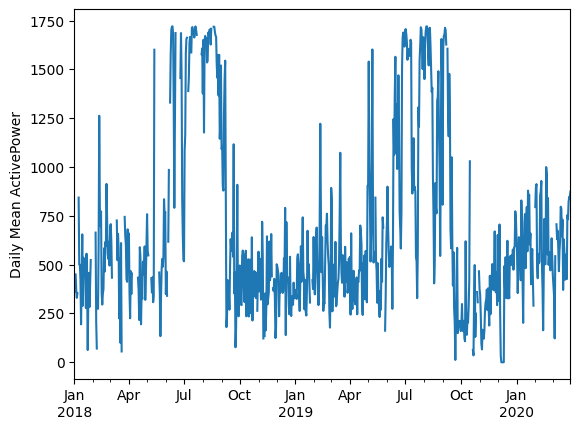

In [417]:
df['ActivePower'].resample('D').mean().plot()
plt.ylabel('Daily Mean ActivePower')
plt.savefig('./figs/DailyMeanActivePower')

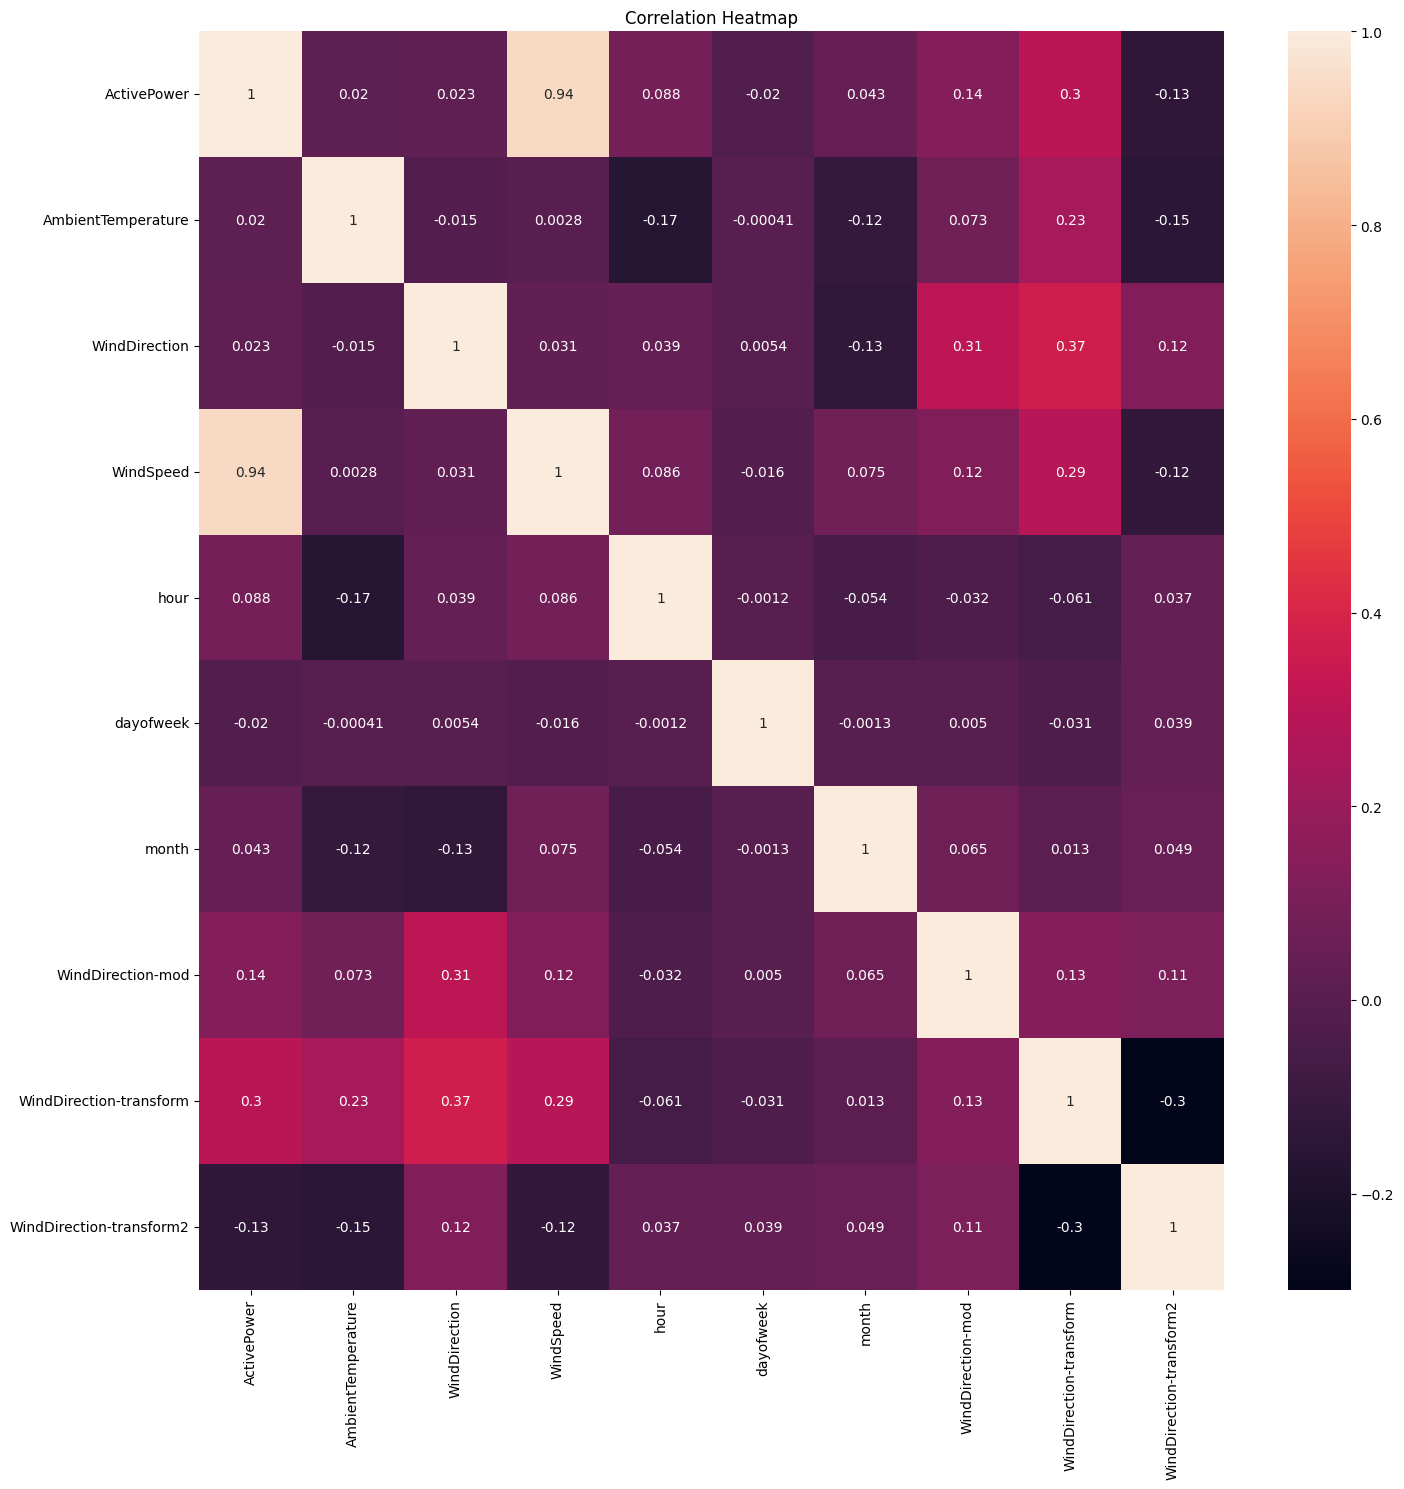

In [469]:
fig,ax=plt.subplots(figsize=(15,15))
g = sns.heatmap(df.corr(),fmt='.2g',annot=True,ax=ax)
g.set_title('Correlation Heatmap')
plt.tight_layout()
plt.savefig('./figs/CorrelationHeatmap.png')

In [19]:
df.drop_duplicates(inplace=True)

Let's take a visual look at the data.

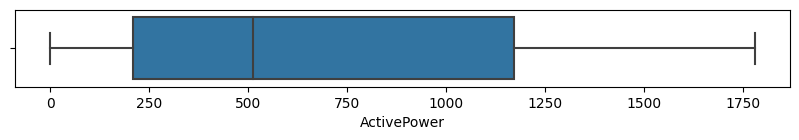

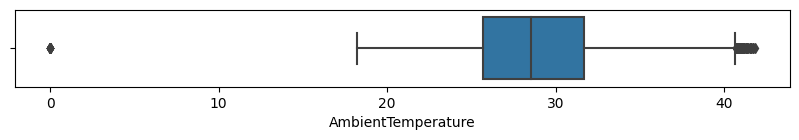

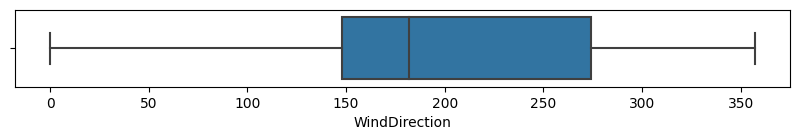

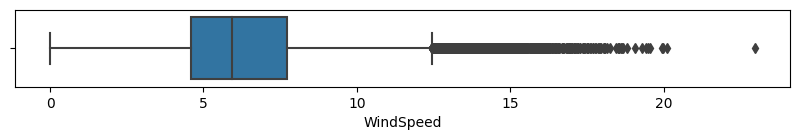

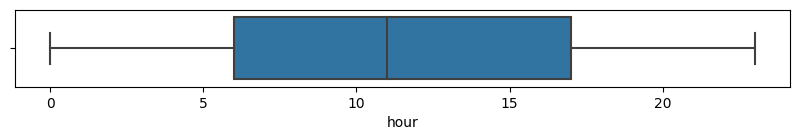

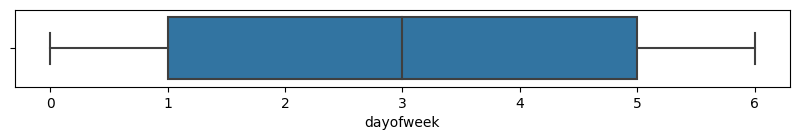

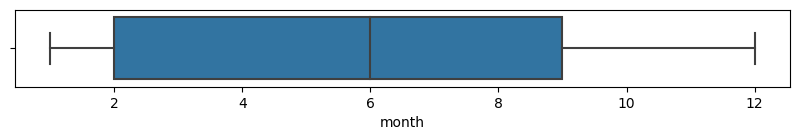

In [416]:
for column in df.columns:
    fig,ax=plt.subplots(figsize=(10,1))
    sns.boxplot(data=df,x=column,ax=ax)

<AxesSubplot: >

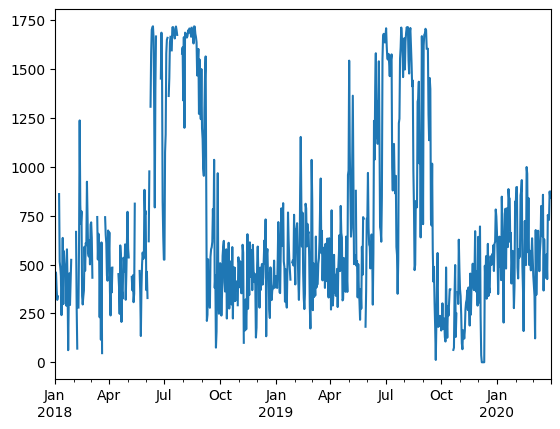

In [21]:
df['ActivePower'].resample('D').mean().plot()

There are very distinct spikes in power generation in the late summer.

In [409]:
df['hour'] = df.index.hour
df['dayofweek'] = df.index.dayofweek
df['month'] = df.index.month

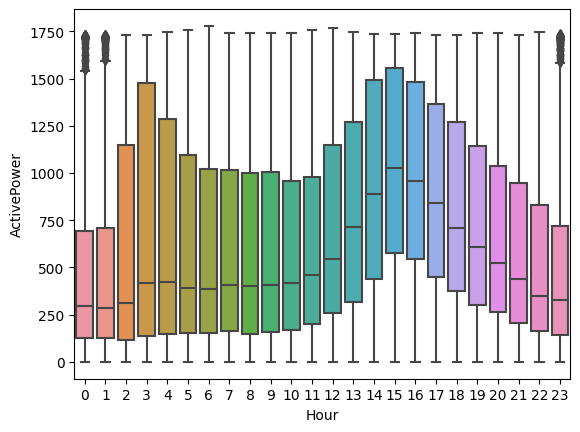

In [414]:
sns.boxplot(data=df,x='hour',y='ActivePower')
plt.xlabel('Hour')
plt.savefig('./figs/ActivePowerHour.png')

There is a distinct hourly seasonality.

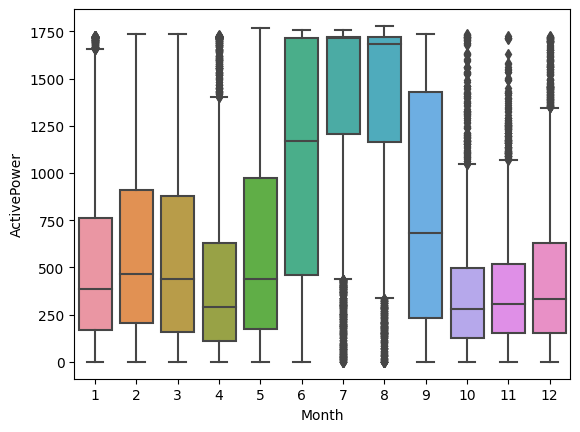

In [415]:
sns.boxplot(data=df,x='month',y='ActivePower')
plt.xlabel('Month')
plt.savefig('./figs/ActivePowerMonth.png')

There is also a distinct monthly seasonality, as seen in the line-plot above.

<AxesSubplot: xlabel='dayofweek', ylabel='ActivePower'>

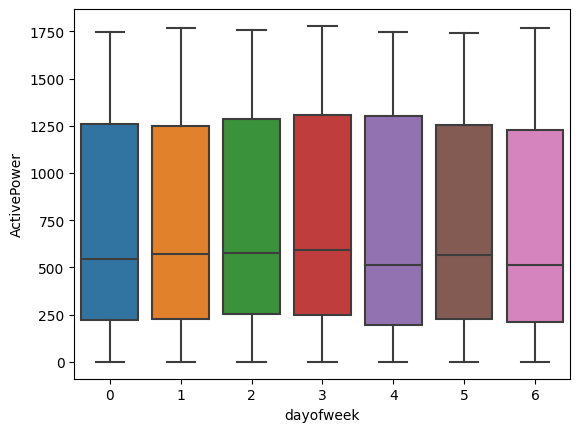

In [25]:
sns.boxplot(data=df,x='dayofweek',y='ActivePower')

There is no distinct day of week seasonality, which makes sense as the individual days don't tend to correlate with weather like time of day or time of year (month) do.

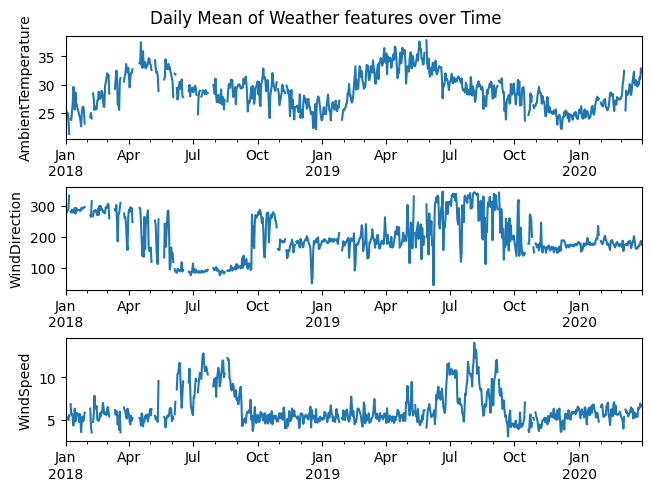

In [426]:
weather_features = ['AmbientTemperature', 'WindDirection', 'WindSpeed']
fig,ax = plt.subplots(3,layout='constrained')
for i in range(len(weather_features)):
    df[weather_features[i]].resample('D').mean().plot(ax=ax[i])
    ax[i].set_ylabel(weather_features[i])
#plt.tight_layout()
fig.suptitle('Daily Mean of Weather features over Time')
fig.savefig('./figs/DailyMeanWeather.png')

<AxesSubplot: >

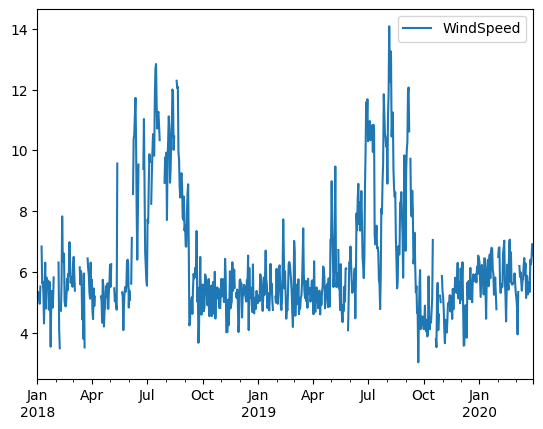

In [413]:
df['WindSpeed'].resample('D').mean().plot()
plt.ylabel('Daily Mean WindSpeed')
plt.savefig

This confirms an expected correlation between WindSpeed and RotorRPM.

<AxesSubplot: xlabel='WindSpeed', ylabel='ActivePower'>

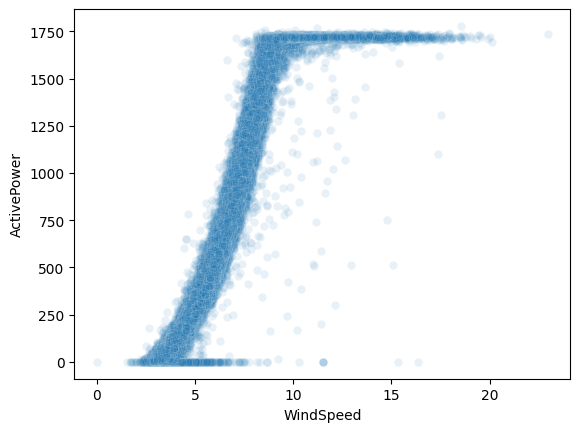

In [27]:
sns.scatterplot(data=df,x='WindSpeed',y='ActivePower',alpha=0.1)

Strong pattern with between WindSpeed and ActivePower. The turbine seems to have a maximum power output regardless of how fast the wind blows, after a certain point. There is also a minimum wind speed before the force of the wind overpowers the friction in the turbine. This varies a little on other factors (such as wind direction, ambient temperature, etc.) so the same wind speed can generate different amounts of power. 

Some days no power was generated. This could be times where the turbine was shut off for maintenance or other reasons unrelated to weather.

This looks like a sigmoid function that has been shifted and stretched. We can some curve to this data to build a purely physical data-driven model. This model would rely upon weather forecasting to provide input wind speed, for our predicted power generation. We will test this model in the next section.

<AxesSubplot: xlabel='AmbientTemperatue', ylabel='ActivePower'>

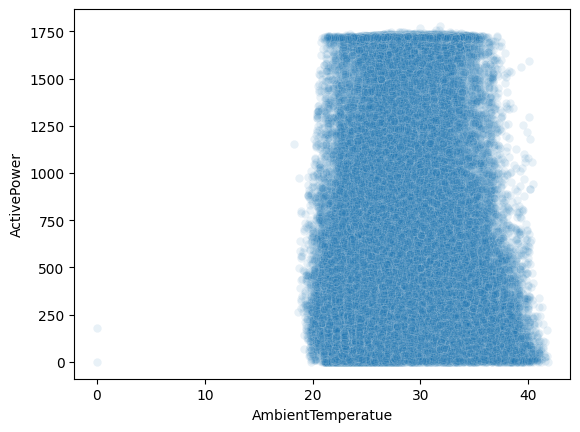

In [28]:
sns.scatterplot(data=df,x='AmbientTemperatue',y='ActivePower',alpha=0.1)

There is very little correlation between AmbientTemperature and ActivePower, as indicated in the correlation matrix.

<AxesSubplot: xlabel='WindDirection', ylabel='ActivePower'>

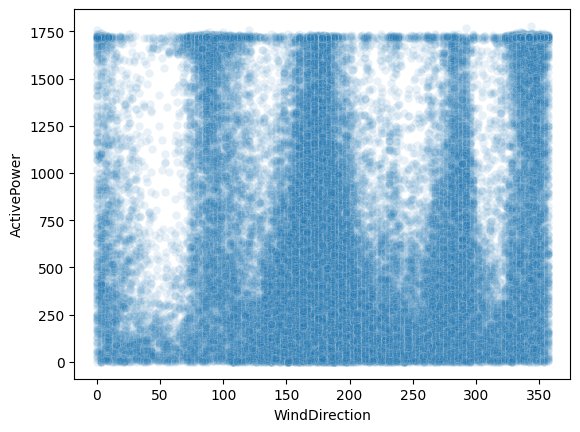

In [29]:
sns.scatterplot(data=df,x='WindDirection',y='ActivePower',alpha=0.1)

There are distinct bands of WindDirection corresponding to strong power generation. These are centered at 90, 180, 270, and 0/360. As these are all multiples of 90 degrees, these likely correspond to hitting the turbune blades face-on or side-on, with dips in the power when the wind isn't blowing at an angle close to these.

For our purposes, the reverse of the wind direction is essentially identical for turning the turbine.

In [445]:
df['WindDirection-mod'] = df['WindDirection'].mod(180)

In [446]:
np.corrcoef(df.dropna()['WindDirection-mod'],df.dropna()['ActivePower'])

array([[1.        , 0.13577281],
       [0.13577281, 1.        ]])

This term has a stronger correlation with ActivePower than the untransformed variable.

Text(0, 0.5, 'WindDirection-mod')

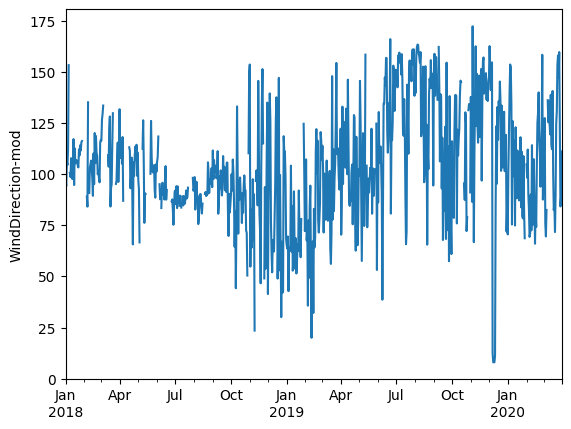

In [448]:
df['WindDirection-mod'].resample('D').mean().plot()
plt.ylabel('WindDirection-mod')

The daily average is sort of noisy but does have a sort of sinusoidal trend.

In [34]:
np.corrcoef(df.dropna()['WindDirection-transform'],df.dropna()['ActivePower'])

array([[1.        , 0.21070099],
       [0.21070099, 1.        ]])

In [462]:
np.corrcoef(df.dropna()['WindDirection'].resample('D').mean(),df.dropna()['ActivePower'].resample('D').mean())

array([[nan, nan],
       [nan, nan]])

This transformed WindDirection variable has a stronger correlation 

### Building models

For our models, we will only historical ActivePower values (for time series models) and data which can be predicted from weather forecasts (such as wind temperature and ambient temperature).

The goal is to predict average power generation for 15 days, we will take the daily average of our data and work with that. This will cause us to lose hour information but this is acceptable for daily average predictions.

Let's grab only ActivePower and the weather-related data, look at if we need to apply some transform, then normalize.

In [473]:
forecast_df = df[['ActivePower','AmbientTemperature','WindDirection','WindSpeed']].resample('D').mean().dropna()

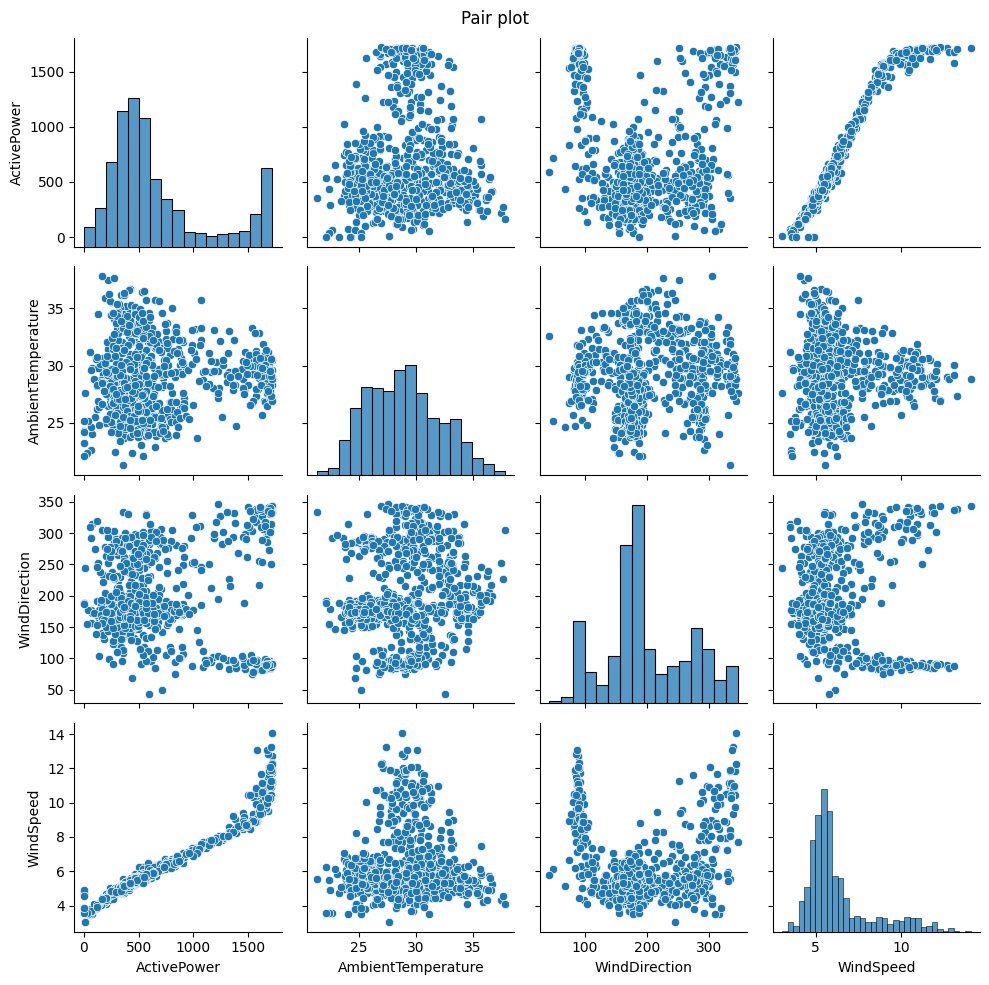

In [475]:
g = sns.pairplot(data=forecast_df)
g.fig.suptitle('Pair plot')
plt.tight_layout()
plt.savefig('./figs/PairPlot.png')

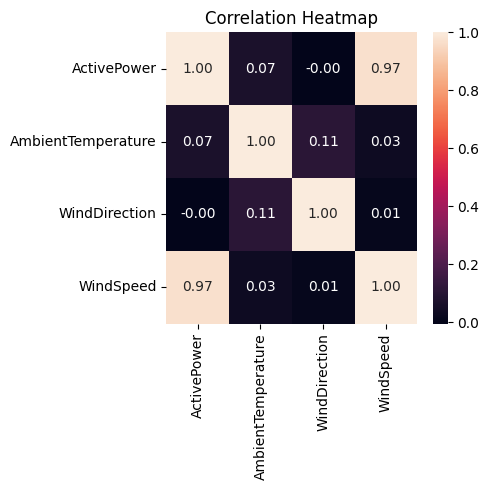

In [474]:
fig,ax=plt.subplots(figsize=(5,5))
g = sns.heatmap(forecast_df.corr(),fmt='.2f',annot=True,ax=ax)
g.set_title('Correlation Heatmap')
plt.tight_layout()
plt.savefig('./figs/CorrelationHeatmap.png')

In [464]:
print('Total rows: ',len(forecast_df))

Total rows:  742


In [73]:
print('Mean: ',forecast_df['WindSpeed'].mean(),', Median: ',forecast_df['WindSpeed'].median(),', Skew: ',forecast_df['WindSpeed'].skew())

Mean:  4.2134609667714836e-16 , Median:  -0.3301171191683581 , Skew:  1.4727707198903008


The WindSpeed data is highly skewed but because it is by far the dominant factor influencing ActivePower and has a nonlinear relationship with ActivePower, so we will leave it alone. 

Let's normalize the input data.

In [490]:
forecast_df['WindSpeed'] = (forecast_df['WindSpeed']-forecast_df['WindSpeed'].mean())/forecast_df['WindSpeed'].std()
forecast_df['AmbientTemperature'] = (forecast_df['AmbientTemperature']-forecast_df['AmbientTemperature'].mean())/forecast_df['AmbientTemperature'].std()
forecast_df['WindDirection'] = (forecast_df['WindDirection']-forecast_df['WindDirection'].mean())/forecast_df['WindDirection'].std()

For validation purposes, split the datasets two ways. The first set will be the first 80% of the data set for training and the next 15 days for testing. The second set will be the whole dataset minus the last 15 days for training, and the last 15 days for testing.

In [476]:
int(0.8*len(forecast_df))

593

In [478]:
(int(0.8*len(forecast_df))+15)

608

In [477]:
len(forecast_df)

742

In [491]:
train_80 = forecast_df[:int(0.8*len(forecast_df))]
test_80 = forecast_df[int(0.8*len(forecast_df)):(int(0.8*len(forecast_df))+15)]
train_80_X = train_80.drop('ActivePower',axis=1)
train_80_Y = train_80['ActivePower']
test_80_X = test_80.drop('ActivePower',axis=1)
test_80_Y = test_80['ActivePower']

train_last = forecast_df[:-15]
test_last = forecast_df[-15:]
train_last_X = train_last.drop('ActivePower',axis=1)
train_last_Y = train_last['ActivePower']
test_last_X = test_last.drop('ActivePower',axis=1)
test_last_Y = test_last['ActivePower']

sarima_train_80 = train_80['ActivePower']
sarima_test_80 = test_80['ActivePower']

sarima_train_80_2 = df['ActivePower'][:int(0.8*len(forecast_df))]
sarima_test_80_2 = df['ActivePower'][int(0.8*len(forecast_df)):(int(0.8*len(forecast_df))+700)]

sarima_train_last = train_last['ActivePower']
sarima_test_last = test_last['ActivePower']

In [480]:
len(train_80_Y)

593

In [481]:
len(train_last_Y)

727

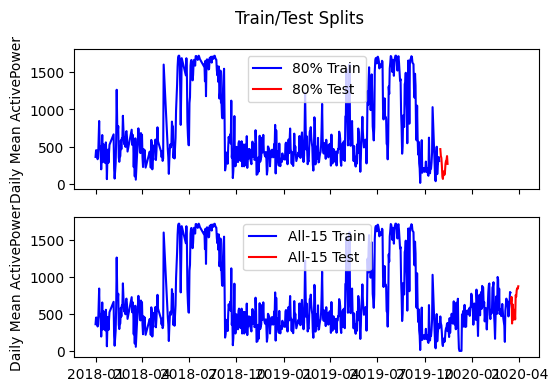

In [492]:
fig,ax = plt.subplots(2,figsize=(6,4),sharex=True)
ax[0].plot(train_80_Y,color='blue')
ax[0].plot(test_80_Y,color='red')
ax[0].legend(['80% Train','80% Test'])
ax[0].set_ylabel('Daily Mean ActivePower')
ax[1].plot(train_last_Y,color='blue')
ax[1].plot(test_last_Y,color='red')
ax[1].legend(['All-15 Train','All-15 Test'])
ax[1].set_ylabel('Daily Mean ActivePower')
fig.suptitle('Train/Test Splits')
plt.savefig('./figs/TrainTest.png')

In [89]:
def report_performance(actual,pred):
    print(f"MSE: {mean_squared_error(actual,pred):.2f}, MAPE: {mean_absolute_percentage_error(actual,pred):.2f}")
    print(f"MAE: {mean_absolute_error(actual,pred):.2f}, MaxE: {max_error(actual,pred):.2f}")
    print(f"R2: {r2_score(actual,pred):.2f}")
    
def plot_actual_pred(actual,pred):
    x = actual.index
    plt.figure()
    plt.plot(x,actual)
    plt.plot(x,pred)
    plt.legend(['actual','pred'])
    plt.xlabel('Date')
    plt.ylabel('ActivePower')
    plt.xticks(rotation=-45)
    plt.show()
    plt.close()

#### Linear Regression Baseline

Linear Regression 80%:
MSE: 6490.12, MAPE: 0.36
MAE: 76.29, MaxE: 113.77
R2: 0.49


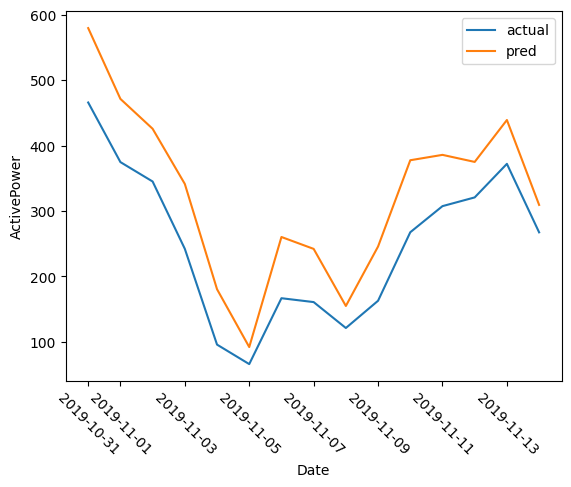

                            OLS Regression Results                            
Dep. Variable:            ActivePower   R-squared:                       0.946
Model:                            OLS   Adj. R-squared:                  0.946
Method:                 Least Squares   F-statistic:                     3455.
Date:                Fri, 27 Jan 2023   Prob (F-statistic):               0.00
Time:                        13:35:57   Log-Likelihood:                -3651.5
No. Observations:                 593   AIC:                             7311.
Df Residuals:                     589   BIC:                             7329.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                679.8126      4

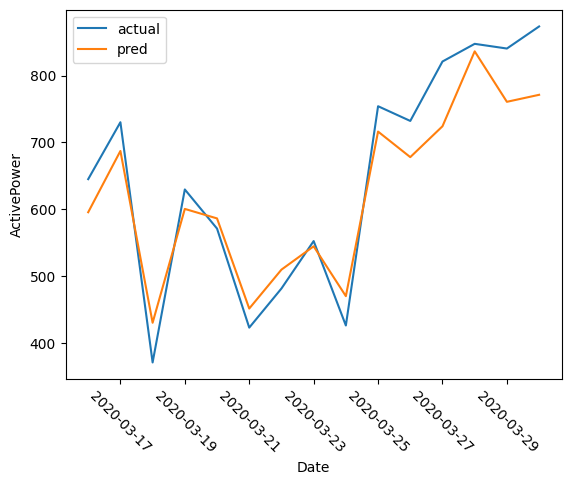

                            OLS Regression Results                            
Dep. Variable:            ActivePower   R-squared:                       0.946
Model:                            OLS   Adj. R-squared:                  0.945
Method:                 Least Squares   F-statistic:                     4194.
Date:                Fri, 27 Jan 2023   Prob (F-statistic):               0.00
Time:                        13:35:58   Log-Likelihood:                -4436.8
No. Observations:                 727   AIC:                             8882.
Df Residuals:                     723   BIC:                             8900.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                676.0460      4

In [493]:
train_80_X_OLS = sm.add_constant(train_80_X)
test_80_X_OLS = sm.add_constant(test_80_X)
train_last_X_OLS = sm.add_constant(train_last_X)
test_last_X_OLS = sm.add_constant(test_last_X)

lr_model_80 = sm.OLS(train_80_Y,train_80_X_OLS).fit()
lr_model_80_pred = lr_model_80.predict(test_80_X_OLS)
print('Linear Regression 80%:')
report_performance(test_80_Y,lr_model_80_pred)
plot_actual_pred(test_80_Y,lr_model_80_pred)
print(lr_model_80.summary())

print('\n\n-------\n')

lr_model_last = sm.OLS(train_last_Y,train_last_X_OLS).fit()
lr_model_last_pred = lr_model_last.predict(test_last_X_OLS)
print('Linear Regression All - 15days:')
report_performance(test_last_Y,lr_model_last_pred)
plot_actual_pred(test_last_Y,lr_model_last_pred)
print(lr_model_last.summary())

The models did quite well, with an average error of 32% for the model using 80% of the data on the test set, and an average error of only 8% on the test set when using all of the data minus the last 15 days.

WindDirection-mod has a p-value much greater than 0.05, so let's drop and re-run. 

All of the variables are significant and we see a small improvement in performance for the 80% model. The performance remains about the same for the last 15 model.

#### Predicting ActivePower strictly from WindSpeed.

A sigmoid function has the form 

$$(1+e^{-x})^{-1}.$$ 

Let's add 4 parameters to this function to better fit our data. These parameters will be 

$$a = \text{Vertical shift parameter},$$ 

$$b = \text{Vertical stretch parameter},$$

$$c = \text{Horizontal stretch parameter},$$

$$d = \text{Horizontal shift parameter}.$$ 

We then get a model of the form 

$$a + b(1+e^{-(cx+d)})^{-1}.$$

We'll use SciPy's curve_fit to build the model.

In [91]:
def model_sigmoid(x,a,b,c,d):
    return a+b/(1.0+np.exp(-(c*x+d)))

In [141]:
params,param_cov = curve_fit(model_sigmoid,forecast_df['WindSpeed'],forecast_df['ActivePower'],[1,1700,10,1])
print(params)

[-1.05357570e+02  1.87700683e+03  1.33780198e+00 -2.35157935e-01]


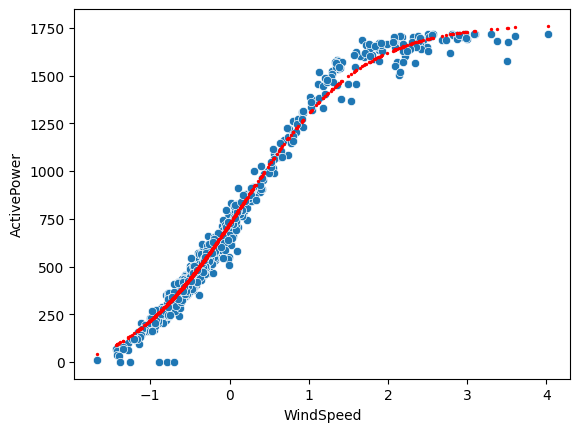

In [494]:
pred = model_sigmoid(forecast_df['WindSpeed'],params[0],params[1],params[2],params[3])
sns.scatterplot(data=forecast_df,x='WindSpeed',y='ActivePower')
plt.scatter(forecast_df['WindSpeed'],pred,color='red',s=2)

In [140]:
report_performance(forecast_df['ActivePower'],pred)

MSE: 2593.04, MAPE: 5633978714646406.00
MAE: 37.35, MaxE: 315.21
R2: 0.99


MAPE is quite high for this plot, likely due to the outliers of ActivePower close to 0, while the prediction is in line with the predicted values. If we filter out small values of ActivePower, we should see a MAPE inline with expectations.

In [128]:
mask = forecast_df['ActivePower']>2
report_performance(forecast_df.loc[mask,'ActivePower'],pred[mask])

MSE: 2265.50, MAPE: 0.07
MAE: 36.08, MaxE: 202.04
R2: 0.99


Indeed we see a low MAPE value. This makes sense to be better than the linear regression as it takes advantage of the true relationship between WindSpeed and ActivePower. However, this has been using the entire dataset to predict ActivePower values, and only measuring the training error. Let's reassess in a similar manner as we did with LinearRegression.

Curve Fit 80%:
MSE: 1336.62, MAPE: 0.17
MAE: 29.60, MaxE: 89.96
R2: 0.90


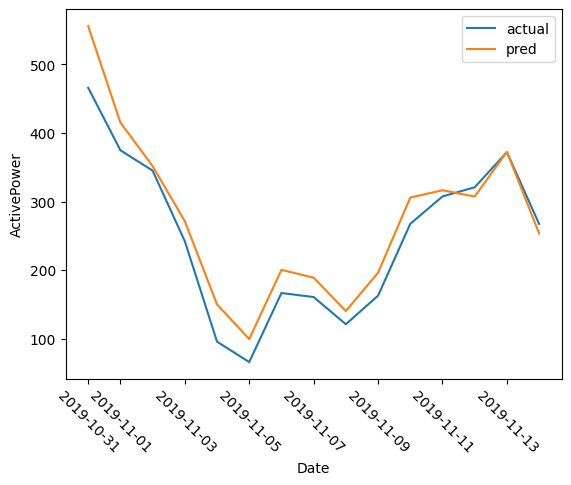



-------

Curve Fit All - 15days:
MSE: 4530.17, MAPE: 0.09
MAE: 57.35, MaxE: 148.29
R2: 0.83


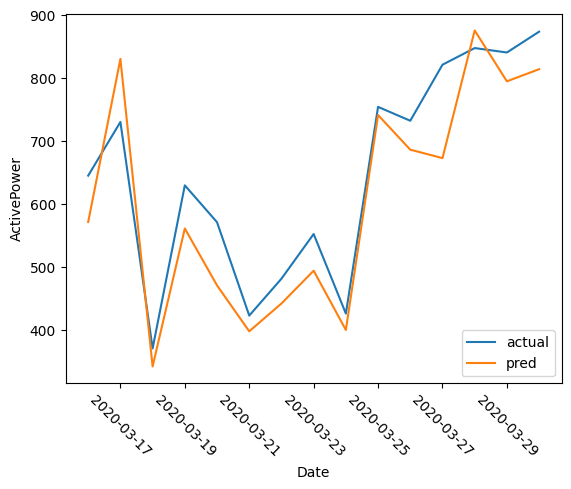

In [508]:
params_80,pcov = curve_fit(model_sigmoid,train_80_X['WindSpeed'],train_80_Y,[1,1700,10,1])
cf_model_80_pred = model_sigmoid(test_80_X_CF,params_80[0],params_80[1],params_80[2],params_80[3])
cf_model_80_pred.index = test_80_Y.index
print('Curve Fit 80%:')
mask = test_80_Y > 2
report_performance(test_80_Y[mask],cf_model_80_pred[mask])
plot_actual_pred(test_80_Y,cf_model_80_pred)

print('\n\n-------\n')

params_last,pcov = curve_fit(model_sigmoid,train_last_X['WindSpeed'],train_last_Y,[1,1700,10,1])
cf_model_last_pred = model_sigmoid(test_last_X_CF,params_last[0],params_last[1],params_last[2],params_last[3])
cf_model_last_pred.index = test_last_Y.index
print('Curve Fit All - 15days:')
mask = test_last_Y > 2
report_performance(test_last_Y[mask],cf_model_last_pred[mask])
plot_actual_pred(test_last_Y,cf_model_last_pred)

We see an expected degradation of performance when using only a subset of the data, but both are better than the linear regression models by a few % of mean absolute percentage error. 

#### SARIMA/SARIMAX Models

Let's build some time-series models which take into account the history of ActivePower.

We will build a purely SARIMA model using pmdarima's auto_arima, and two SARIMAX models. 

One SARIMAX model will include only WindSpeed, the other will include all the features.

First, let's test to see the stationarity of ActivePower by using the Augmented Dickey-Fuller test. A  low P Value here implies the series is indeed stationary.

In [153]:
adfuller_result = adfuller(forecast_df['ActivePower'],autolag='AIC')
print(f'ADF Statistic: {adfuller_result[0]:.3f}')
print(f'P Value: {adfuller_result[1]:.3f}')
print(adfuller_result)

ADF Statistic: -3.240
P Value: 0.018
(-3.2398560997609307, 0.01779049878685736, 7, 734, {'1%': -3.439290485895927, '5%': -2.8654856985173414, '10%': -2.568871126669587}, 9783.694975323666)


The P Value is lower than 0.05, so we say the daily average ActivePower is indeed stationary. This gives us extra info for our SARIMA/SARIMAX models.

For building our SARIMA models, we will use pmdarima's auto_arima function. Because the series is stationary, we will enforce d (differencing term capturing non-stationarity) and D (seasonal d term) = 0. We will also use p+d+q+P+D+Q <= 6.

In [271]:
sarima_model = pmdarima.auto_arima(sarima_train_last, seasonal=True, stationary=True,
                                    start_p=1, d=0, start_q=0, 
                                    max_p=6, max_q=6,
                                    start_P=0, D=0, start_Q=0,
                                    max_P=6, max_Q=6,
                                    m=31, 
                                    information_criterion='aic', n_fits=100, trace=True)

Performing stepwise search to minimize aic
 ARIMA(1,0,0)(0,0,0)[31] intercept   : AIC=9902.691, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[31] intercept   : AIC=10972.984, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[31] intercept   : AIC=9903.737, Time=0.49 sec
 ARIMA(0,0,1)(0,0,1)[31] intercept   : AIC=10387.215, Time=1.43 sec
 ARIMA(0,0,0)(0,0,0)[31]             : AIC=11836.967, Time=0.01 sec
 ARIMA(1,0,0)(0,0,1)[31] intercept   : AIC=9903.805, Time=0.56 sec
 ARIMA(1,0,0)(1,0,1)[31] intercept   : AIC=9905.735, Time=1.02 sec
 ARIMA(2,0,0)(0,0,0)[31] intercept   : AIC=9888.048, Time=0.04 sec
 ARIMA(2,0,0)(1,0,0)[31] intercept   : AIC=9889.616, Time=1.49 sec
 ARIMA(2,0,0)(0,0,1)[31] intercept   : AIC=9889.649, Time=0.56 sec
 ARIMA(2,0,0)(1,0,1)[31] intercept   : AIC=9891.610, Time=1.95 sec
 ARIMA(3,0,0)(0,0,0)[31] intercept   : AIC=9882.796, Time=0.06 sec
 ARIMA(3,0,0)(1,0,0)[31] intercept   : AIC=9884.166, Time=1.66 sec
 ARIMA(3,0,0)(0,0,1)[31] intercept   : AIC=9884.207, Time=0.62 sec
 ARIMA(3,0,0)(1,

In [202]:
sarima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  593
Model:               SARIMAX(6, 0, 0)   Log Likelihood               -4039.375
Date:                Thu, 26 Jan 2023   AIC                           8094.750
Time:                        13:08:39   BIC                           8129.832
Sample:                             0   HQIC                          8108.414
                                - 593                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     50.0619     21.928      2.283      0.022       7.084      93.040
ar.L1          0.7191      0.036     19.740      0.000       0.648       0.790
ar.L2          0.0569      0.042      1.363      0.173      -0.025       0.139
ar.L3         -0.0022      0.048     -0.047      0.963      -0.096       0.091
ar.L4          0.0730      0.051      1.445      0.148      -0.026       0.172
ar.L5          0.0017      0.050      0.034      0.973      -0.097       0.100
ar.L6          0.0815      0.042      1.948      0.051      -0.001       0.163
sigma2      4.859e+04   2541.501     19.120      0.000    4.36e+04    5.36e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                19.06
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               1.16   Skew:                             0.13
Prob(H) (two-sided):                  0.31   Kurtosis:                         3.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

MSE: 60603.64, MAPE: 1.34
MAE: 203.93, MaxE: 536.50
R2: -3.74


C:\Users\alexpc2red\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\alexpc2red\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


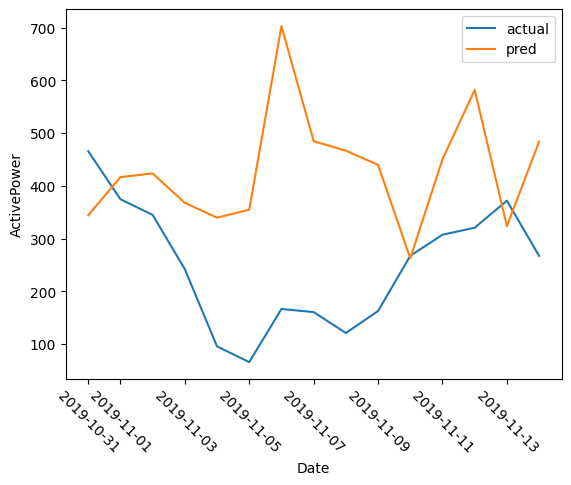

In [503]:
sarima_pred_80 = SARIMAX(sarima_train_80,order=(6,0,0),seasonal_order=(0,0,0,0)).fit().predict(start=1,end=15)
sarima_pred_80.index = sarima_test_80.index
report_performance(sarima_test_80,sarima_pred_80)
plot_actual_pred(sarima_test_80,sarima_pred_80)

MSE: 87552.45, MAPE: 0.37
MAE: 258.60, MaxE: 515.82
R2: -2.26


C:\Users\alexpc2red\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\alexpc2red\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


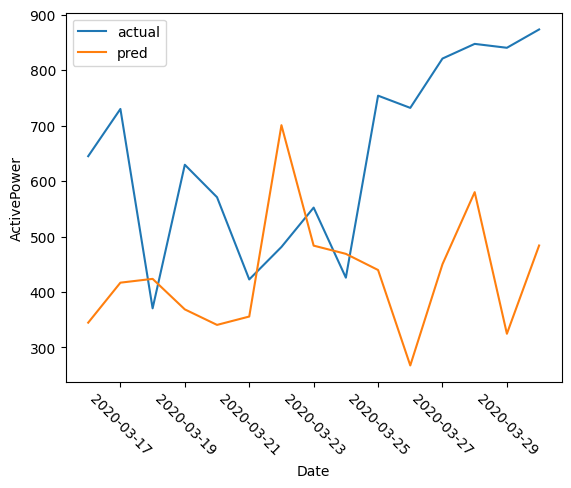

In [502]:
sarima_pred_last = SARIMAX(sarima_train_last,order=(6,0,0),seasonal_order=(0,0,0,12)).fit().predict(start=1,end=15)
sarima_pred_last.index = sarima_test_last.index
report_performance(sarima_test_last,sarima_pred_last)
plot_actual_pred(sarima_test_last,sarima_pred_last)

#### XGBoost Model

The last model we will test is the XGBoost boosted trees model. 

[0]	validation_0-rmse:615.65999	validation_1-rmse:179.55951
[1]	validation_0-rmse:435.48848	validation_1-rmse:113.75761
[2]	validation_0-rmse:308.46298	validation_1-rmse:67.42562
[3]	validation_0-rmse:219.50295	validation_1-rmse:37.11856
[4]	validation_0-rmse:157.29922	validation_1-rmse:26.12322
[5]	validation_0-rmse:114.18522	validation_1-rmse:27.79589
[6]	validation_0-rmse:84.40715	validation_1-rmse:31.20881
[7]	validation_0-rmse:64.03144	validation_1-rmse:35.33626
[8]	validation_0-rmse:49.77561	validation_1-rmse:39.15474
[9]	validation_0-rmse:40.34337	validation_1-rmse:42.38490
[10]	validation_0-rmse:34.02451	validation_1-rmse:44.85073
[11]	validation_0-rmse:29.68442	validation_1-rmse:46.22476
[12]	validation_0-rmse:26.75202	validation_1-rmse:48.58955
[13]	validation_0-rmse:24.90407	validation_1-rmse:49.37253
[14]	validation_0-rmse:23.45636	validation_1-rmse:50.13920
[15]	validation_0-rmse:22.21730	validation_1-rmse:50.58237
[16]	validation_0-rmse:21.24190	validation_1-rmse:50.79632

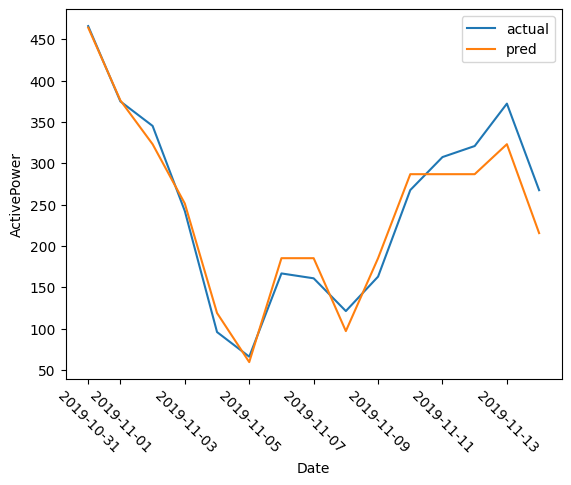

[0.00147206 0.00154235 0.9969856 ]


---------------

[0]	validation_0-rmse:579.23372	validation_1-rmse:478.05103
[1]	validation_0-rmse:409.58984	validation_1-rmse:343.45527
[2]	validation_0-rmse:290.24165	validation_1-rmse:253.84135
[3]	validation_0-rmse:206.65866	validation_1-rmse:187.83663
[4]	validation_0-rmse:148.26244	validation_1-rmse:141.72634
[5]	validation_0-rmse:107.76544	validation_1-rmse:107.67278
[6]	validation_0-rmse:79.92295	validation_1-rmse:83.32270
[7]	validation_0-rmse:60.96240	validation_1-rmse:67.27402
[8]	validation_0-rmse:47.94107	validation_1-rmse:55.14817
[9]	validation_0-rmse:39.56220	validation_1-rmse:48.64961
[10]	validation_0-rmse:33.77657	validation_1-rmse:43.58891
[11]	validation_0-rmse:30.19107	validation_1-rmse:40.95982
[12]	validation_0-rmse:27.81219	validation_1-rmse:39.31632
[13]	validation_0-rmse:26.27637	validation_1-rmse:38.66200
[14]	validation_0-rmse:25.09287	validation_1-rmse:38.24450
[15]	validation_0-rmse:24.03830	validation_1-rmse:38.09135


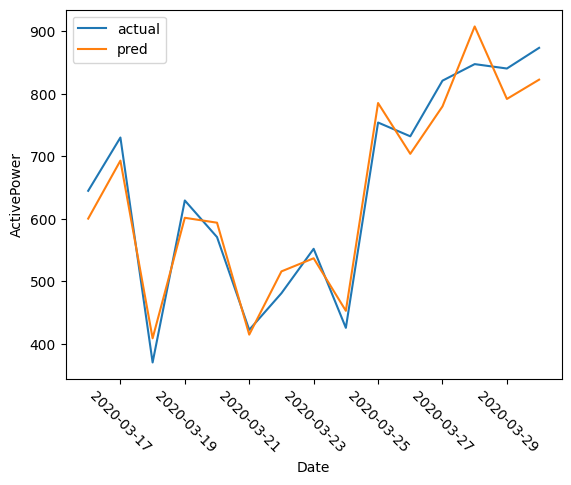

[0.00214704 0.00181568 0.9960373 ]


In [512]:
xgb_model = xgboost.XGBRegressor(n_estimators=1000,early_stopping_rounds=50)
xgb_model.fit(train_80_X, train_80_Y, 
              eval_set=[(train_80_X, train_80_Y),(test_80_X, test_80_Y)],
              verbose=True
             )
xgb_pred_80 = pd.Series(xgb_model.predict(test_80_X))
xgb_pred_80.index = test_80_Y.index
print('XGBoost 80%: ')
report_performance(test_80_Y,xgb_pred_80)
plot_actual_pred(test_80_Y,xgb_pred_80)
print(xgb_model.feature_importances_)

print('\n\n---------------\n')

xgb_model = xgboost.XGBRegressor(n_estimators=1000,early_stopping_rounds=50)
xgb_model.fit(train_last_X, train_last_Y, 
              eval_set=[(train_last_X, train_last_Y),(test_last_X, test_last_Y)],
              verbose=True
             )
xgb_pred_last = pd.Series(xgb_model.predict(test_last_X))
xgb_pred_last.index = test_last_Y.index
print('XGBoost All - Last 15 days: ')
report_performance(test_last_Y,xgb_pred_last)
plot_actual_pred(test_last_Y,xgb_pred_last)
print(xgb_model.feature_importances_)

The XGBoost model with 80% of the data performs better than both linear regression models and far better than the curve fit 80% model. The XGBoost All - Last 15 Days model performs on par with the similar curve fit model. 

As expected with the strength of the correlation between WindSpeed and ActivePower, WindSpeed got the lion's share of importance.

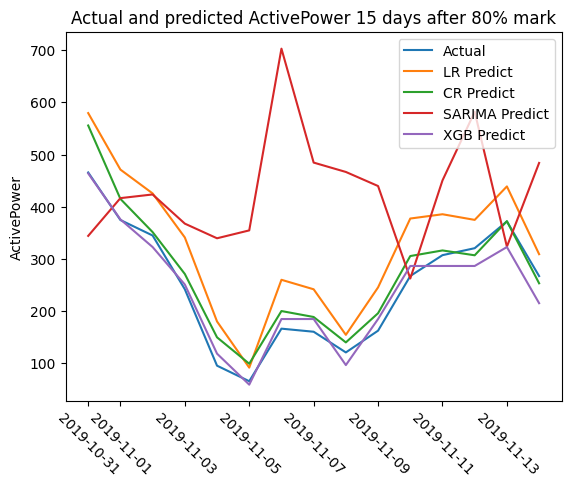

In [523]:
plt.plot(test_80_Y)
plt.plot(lr_model_80_pred)
plt.plot(cf_model_80_pred)
plt.plot(sarima_pred_80)
plt.plot(xgb_pred_80)
plt.xticks(rotation=-45)
plt.legend(['Actual', 'LR Predict', 'CR Predict', 'SARIMA Predict', 'XGB Predict'])
plt.ylabel('ActivePower')
plt.title('Actual and predicted ActivePower 15 days after 80% mark')
plt.savefig('./figs/80activepowerpred.png')

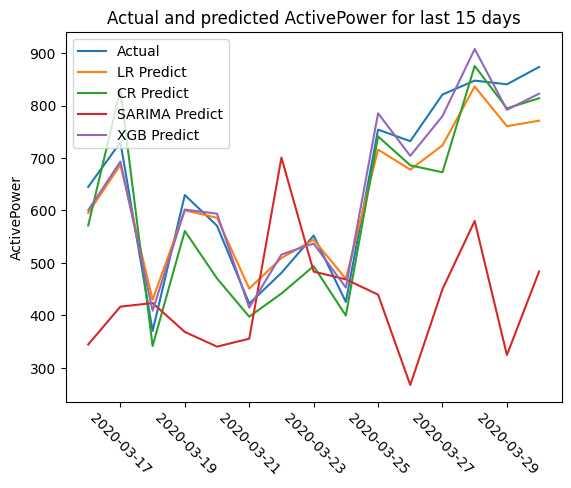

In [525]:
plt.plot(test_last_Y)
plt.plot(lr_model_last_pred)
plt.plot(cf_model_last_pred)
plt.plot(sarima_pred_last)
plt.plot(xgb_pred_last)
plt.xticks(rotation=-45)
plt.legend(['Actual', 'LR Predict', 'CR Predict', 'SARIMA Predict', 'XGB Predict'])
plt.ylabel('ActivePower')
plt.title('Actual and predicted ActivePower for last 15 days')
plt.savefig('./figs/allm15activepowerpred.png')